In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb
import sc_eVIP

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/A549.'+PROTEIN

counts=20000

FIGS=DATA+'/2021-03-22_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS

/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2021-03-22_Figures/


In [3]:
adata=sc.read(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.regress_out_vbc.analysis.1000cells.new_format.h5ad',cache=False)
adata

Only considering the two last: ['.new_format', '.h5ad'].
Only considering the two last: ['.new_format', '.h5ad'].


AnnData object with n_obs × n_vars = 90262 × 1145 
    obs: 'batch', 'known', 'n_counts', 'n_genes', 'percent_mito', 'n_counts_downsampled', 'n_counts_original', 'vbc.counts', 'batch_num4', 'batch_num7', 'batch_num11', 'batch_num8', 'batch_num13', 'batch_num23', 'batch_num9', 'batch_num2', 'batch_num24', 'batch_num10', 'batch_num12', 'batch_num16', 'batch_num20', 'batch_num18', 'batch_num25', 'batch_num31', 'batch_num28', 'batch_num5', 'batch_num14', 'batch_num15', 'batch_num29', 'batch_num3', 'batch_num6', 'batch_num22', 'batch_num26', 'batch_num17', 'batch_num27', 'batch_num1', 'batch_num19', 'batch_num21', 'batch_num0', 'batch_num30', 'louvain', 'G1.S', 'G2.M', 'M', 'M.G1', 'S', 'phase.multi', 'guide', 'guide.compact', 'A146P', 'K117R', 'Y166H', 'K169K', 'K178K', 'T50P', 'A146V', 'L52F', 'K176Q', 'A155G', 'G60D', 'T158T', 'K88K', 'D119G', 'L159S', 'G13V', 'Q61P', 'D33E', 'S136N', 'K179R', 'T74T', 'G60S', 'Q99E', 'G13R', 'G12D', 'R164Q', 'I36M', 'C185Y', 'I163S', 'P34R', 'G60V', 'G12

In [4]:
#collect the variants into a list
perturb.pp.get_perturbations(adata,'guide.compact')

variants=adata.uns['PS.guide.compact.list']
variants.append('unassigned')
print(variants)
print(len(variants))

['A130V', 'A146P', 'A146T', 'A146V', 'A155G', 'A59E', 'A59G', 'A59T', 'A66A', 'AG11TD', 'AG59GV', 'C118S', 'C185Y', 'D119G', 'D173D', 'D30D', 'D33E', 'D57N', 'E31K', 'E63K', 'F141L', 'G12A', 'G12C', 'G12D', 'G12F', 'G12I', 'G12R', 'G12S', 'G12V', 'G12Y', 'G13C', 'G13E', 'G13R', 'G13V', 'G60D', 'G60S', 'G60V', 'G75A', 'G77A', 'I163S', 'I36M', 'K117N', 'K117R', 'K147N', 'K147T', 'K169K', 'K176Q', 'K178K', 'K179R', 'K5E', 'K88K', 'L159S', 'L19F', 'L52F', 'L79I', 'M111L', 'M170L', 'N26Y', 'P110S', 'P34L', 'P34R', 'Q22H', 'Q22K', 'Q25H', 'Q61A', 'Q61H', 'Q61K', 'Q61L', 'Q61P', 'Q61R', 'Q99E', 'R135T', 'R149K', 'R164Q', 'R41K', 'R68S', 'S136N', 'S17S', 'T127T', 'T144P', 'T144T', 'T158A', 'T158T', 'T20M', 'T20R', 'T20T', 'T50I', 'T50P', 'T50T', 'T58I', 'T74A', 'T74T', 'V112I', 'V14I', 'V14L', 'V8V', 'WT', 'Y166H', 'unassigned']
99


In [5]:
#read in the annotation file to add the clusters to it
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.complete2.csv',sep='\t')

anno.index=anno['Variant']

anno['Position']=anno['Position'].astype('Int32')
anno['Count_pancan']=anno['Count_pancan'].astype('Int32')
anno['Count_ExAC']=anno['Count_ExAC'].astype('Int32')

syn=list(set(anno.loc[anno['control_status']=='synonymous','Variant']).intersection(set(variants)))
print(syn)
impactful=list(set(list(anno.loc[anno['control_status']=='unknown',:].index)).intersection(set(variants)))
print(len(impactful))

#cluster info
sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants_df.index=sorted_variants_df[0]
anno['cluster_color']=sorted_variants_df.loc[anno.index,1]
anno.loc['unassigned','cluster_color']='pink'

['D30D', 'V8V', 'T50T', 'T20T', 'A66A', 'K169K', 'K178K', 'T144T', 'T127T', 'S17S', 'D173D', 'K88K', 'T74T', 'T158T', 'WT']
73


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [6]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


0

In [7]:
for pc_num in [#5,10,
               #20,30,40,
    50,
               #30,40,50
              ]:
    print('PCCCCCCCCCCC ',pc_num)
    for i in range(10):
        print('==============',i)
        for subs in [1000,500,200,100,50,#100,200,1000,#20,10,#50,40,#30,20,10,
            #1000,900,800,700,600,500,400,300,200,
            #         190,180,170,160,150,140,130,120,110,
            #         100,90,80,70,60,

        ]:

            print('cells',subs)

            out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
            cell_ids=list(pd.read_csv(out).iloc[:,0])

            #get subsample
            adata_sub=adata[cell_ids,:].copy()

            #HotellingT2 ========================================
            pcs=min(pc_num,subs-1)
            print('pcs',pcs)
            dataset=pd.DataFrame(adata_sub.obsm['X_pca'][:,:pcs],
                         index=adata_sub.obs_names,
                        columns=range(pcs))
            labels=pd.DataFrame({'label':adata_sub.obs['guide.compact']})
            labels.index=adata_sub.obs_names

            #compute scores and their FDRs
            scores_hotel=sc_eVIP.score.compare_groups_with_reference(dataset,
                                      labels,
                                     variants,
                                      syn,
                                     methods=['HotellingT2'],
                                     n_bootstrap_controls=0)

            scores_all=scores_hotel

            out=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.numPCs'+str(pc_num)+'.csv'
            scores_all.to_csv(out)

PCCCCCCCCCCC  50
============== 0
cells 1000
pcs 50
Found 15/15 controls
99 %cells 500
pcs 50
Found 15/15 controls
99 %cells 200
pcs 50
Found 15/15 controls
99 %cells 100
pcs 50
Found 15/15 controls
99 %cells 50
pcs 49
Found 15/15 controls
99 %============== 1
cells 1000
pcs 50
Found 15/15 controls
99 %cells 500
pcs 50
Found 15/15 controls
99 %cells 200
pcs 50
Found 15/15 controls
99 %cells 100
pcs 50
Found 15/15 controls
99 %cells 50
pcs 49
Found 15/15 controls
99 %============== 2
cells 1000
pcs 50
Found 15/15 controls
99 %cells 500
pcs 50
Found 15/15 controls
99 %cells 200
pcs 50
Found 15/15 controls
99 %cells 100
pcs 50
Found 15/15 controls
99 %cells 50
pcs 49
Found 15/15 controls
99 %============== 3
cells 1000
pcs 50
Found 15/15 controls
99 %cells 500
pcs 50
Found 15/15 controls
99 %cells 200
pcs 50
Found 15/15 controls
99 %cells 100
pcs 50
Found 15/15 controls
99 %cells 50
pcs 49
Found 15/15 controls
99 %============== 4
cells 1000
pcs 50
Found 15/15 controls
99 %cells 500
pcs 5

In [8]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)


In [11]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'

for pc_num in [5,10,
               20,30,40,50,
              ]:
    for i in range(10):
        print(i)
        outs[i]={}
        for subs in [1000,500,200,100,50,
        ]:
            outs[i][subs]={}

            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.numPCs'+str(pc_num)+'.csv'
            scores_real2=pd.read_csv(out2,index_col=0)
            print(scores_real2.head())

            for fdr in [fdr_total]:

                for method in methods:

                    #all variants
                    #============
                    #get impactful variants
                    impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                    ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                    print(method,fdr,'impactful',len(impactful))

                    pre,rec=get_precision_recall(scores_real2,
                                                 method+thestat,
                                                 impactful,fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                           'PCs':pc_num,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'cluster':'all',
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                    res[method]=pd.concat([res[method],res_here])


                    #now, go through each cluster of variants and compute (vs original ctrls)
                    for cl in ['#138D75', '#BB8FCE', 'gold', 'red']:
                        cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                        cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                        variants_here=list(set(cl_variants).union(set(ctrls)))
                        pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                                 method+thestat,
                                                 cl_variants_sig,
                                                     fdr)
                        res_here=pd.DataFrame({'cells':subs,
                                               'PCs':pc_num,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'cluster':cl,
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                        res[method]=pd.concat([res[method],res_here])
                
                
                
    

0
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          20.929339                16.513075                 25.345603   
WT            12.180496                 9.157792                 15.203200   
K179R          9.129735                 6.179258                 12.080212   
Q99E          96.266878                84.765214                107.768542   
T50I         102.101556                90.507653                113.695459   

       HotellingT2.q  
T74T        0.272381  
WT          0.537931  
K179R       0.619048  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          26.949200                23.050729                 30.847671   
WT            10.831766                 6.939338                 14.724195   
K179R          8.598840                 5.598199                 11.599481   
Q99E      

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          20.929342                16.513078                 25.345606   
WT            12.180493                 9.157789                 15.203198   
K179R          9.129734                 6.179257                 12.080212   
Q99E          96.266894                84.765226                107.768561   
T50I         102.101567                90.507663                113.695471   

       HotellingT2.q  
T74T        0.272381  
WT          0.537931  
K179R       0.619048  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          11.431489                 8.057575                 14.805402   
WT             9.690165                 7.311458                 12.068872   
K179R          7.639797                 5.365553                  9.914041   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          20.929340                16.513076                 25.345604   
WT            12.180496                 9.157791                 15.203200   
K179R          9.129735                 6.179258                 12.080213   
Q99E          96.266880                84.765214                107.768545   
T50I         102.101558                90.507656                113.695461   

       HotellingT2.q  
T74T        0.272381  
WT          0.537931  
K179R       0.619048  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          14.836332                10.985287                 18.687376   
WT             9.938004                 7.606575                 12.269433   
K179R         11.131856                 8.347946                 13.915766   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          20.929340                16.513076                 25.345603   
WT            12.180495                 9.157791                 15.203200   
K179R          9.129735                 6.179258                 12.080213   
Q99E          96.266882                84.765216                107.768548   
T50I         102.101559                90.507654                113.695464   

       HotellingT2.q  
T74T        0.272381  
WT          0.537931  
K179R       0.619048  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          17.350886                13.614982                 21.086791   
WT            15.201335                12.215106                 18.187565   
K179R          5.850802                 3.514891                  8.186713   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          30.620785                23.693472                 37.548099   
WT            24.493465                19.992310                 28.994621   
K179R         16.382464                12.874235                 19.890693   
Q99E         143.363893               127.188971                159.538815   
T50I         191.496635               174.910381                208.082889   

       HotellingT2.q  
T74T        0.375202  
WT          0.559373  
K179R       0.672859  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          35.063995                30.200361                 39.927629   
WT            20.726072                14.825341                 26.626802   
K179R         12.649231                 9.197696                 16.100765   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          30.620787                23.693474                 37.548100   
WT            24.493465                19.992309                 28.994621   
K179R         16.382465                12.874236                 19.890693   
Q99E         143.363903               127.188979                159.538827   
T50I         191.496641               174.910386                208.082897   

       HotellingT2.q  
T74T        0.375202  
WT          0.559373  
K179R       0.672859  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          19.812459                15.486885                 24.138033   
WT            20.424781                16.552192                 24.297369   
K179R         10.008219                 7.750154                 12.266284   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          30.620787                23.693473                 37.548100   
WT            24.493465                19.992309                 28.994621   
K179R         16.382466                12.874237                 19.890695   
Q99E         143.363899               127.188974                159.538823   
T50I         191.496637               174.910382                208.082892   

       HotellingT2.q  
T74T        0.375202  
WT          0.559373  
K179R       0.672859  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          17.811882                12.651925                 22.971838   
WT            16.417659                13.667323                 19.167995   
K179R         10.414127                 8.384677                 12.443576   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          30.620788                23.693475                 37.548101   
WT            24.493465                19.992309                 28.994621   
K179R         16.382465                12.874236                 19.890694   
Q99E         143.363902               127.188977                159.538827   
T50I         191.496644               174.910388                208.082901   

       HotellingT2.q  
T74T        0.375202  
WT          0.559373  
K179R       0.672859  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          25.873396                19.936802                 31.809991   
WT            19.951358                15.287060                 24.615657   
K179R          9.462524                 6.458193                 12.466855   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          43.197693                34.831483                 51.563902   
WT            32.809474                27.245818                 38.373130   
K179R         29.958400                25.280695                 34.636106   
Q99E         224.826009               206.936099                242.715920   
T50I         249.880294               230.853790                268.906798   

       HotellingT2.q  
T74T        0.494686  
WT          0.582764  
K179R       0.626383  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          29.066784                24.749024                 33.384543   
WT            23.823103                20.184356                 27.461850   
K179R         20.923886                19.415000                 22.432772   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          43.197689                34.831480                 51.563898   
WT            32.809474                27.245819                 38.373130   
K179R         29.958399                25.280694                 34.636104   
Q99E         224.826004               206.936098                242.715911   
T50I         249.880284               230.853784                268.906785   

       HotellingT2.q  
T74T        0.494686  
WT          0.582764  
K179R       0.626383  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          34.331196                29.348099                 39.314292   
WT            26.112292                22.394339                 29.830245   
K179R         22.596239                18.813595                 26.378883   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          43.197690                34.831481                 51.563898   
WT            32.809474                27.245819                 38.373130   
K179R         29.958399                25.280694                 34.636105   
Q99E         224.826004               206.936096                242.715913   
T50I         249.880287               230.853790                268.906784   

       HotellingT2.q  
T74T        0.494686  
WT          0.582764  
K179R       0.626383  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          35.395994                28.554783                 42.237206   
WT            32.780775                27.473322                 38.088229   
K179R         29.604963                24.616404                 34.593521   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          55.002521                45.823640                 64.181402   
WT            42.748312                36.861168                 48.635457   
K179R         46.116017                40.932647                 51.299386   
Q99E         285.911860               263.360588                308.463132   
T50I         287.308055               264.825294                309.790815   

       HotellingT2.q  
T74T        0.492771  
WT          0.632727  
K179R       0.605656  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          42.309996                36.149691                 48.470301   
WT            34.715659                29.110156                 40.321162   
K179R         39.075306                35.368210                 42.782401   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          55.002518                45.823637                 64.181398   
WT            42.748315                36.861170                 48.635459   
K179R         46.116018                40.932648                 51.299388   
Q99E         285.911844               263.360574                308.463113   
T50I         287.308040               264.825282                309.790798   

       HotellingT2.q  
T74T        0.492771  
WT          0.632727  
K179R       0.605656  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          44.936216                39.173278                 50.699155   
WT            39.625499                33.876331                 45.374668   
K179R         41.349044                35.879663                 46.818425   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          55.002519                45.823638                 64.181399   
WT            42.748315                36.861170                 48.635460   
K179R         46.116019                40.932649                 51.299389   
Q99E         285.911847               263.360577                308.463117   
T50I         287.308046               264.825284                309.790807   

       HotellingT2.q  
T74T        0.492771  
WT          0.632727  
K179R       0.605656  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          50.590638                43.345320                 57.835957   
WT            47.406848                41.883016                 52.930680   
K179R         42.175140                37.760291                 46.589988   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          72.146312                61.308150                 82.984473   
WT            54.140149                46.626773                 61.653526   
K179R         58.429764                51.986518                 64.873011   
Q99E         352.671871               325.506412                379.837330   
T50I         303.411076               280.566780                326.255372   

       HotellingT2.q  
T74T        0.458901  
WT          0.639599  
K179R       0.611373  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          70.384604                62.461503                 78.307704   
WT            53.426474                44.489264                 62.363683   
K179R         39.502653                34.958838                 44.046468   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          72.146313                61.308152                 82.984475   
WT            54.140148                46.626772                 61.653525   
K179R         58.429766                51.986520                 64.873012   
Q99E         352.671877               325.506416                379.837337   
T50I         303.411082               280.566784                326.255381   

       HotellingT2.q  
T74T        0.458901  
WT          0.639599  
K179R       0.611373  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          58.844821                54.016464                 63.673177   
WT            54.018919                48.679470                 59.358368   
K179R         47.590843                42.164408                 53.017279   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          72.146313                61.308152                 82.984475   
WT            54.140149                46.626772                 61.653526   
K179R         58.429767                51.986520                 64.873013   
Q99E         352.671878               325.506417                379.837339   
T50I         303.411077               280.566781                326.255374   

       HotellingT2.q  
T74T        0.458901  
WT          0.639599  
K179R       0.611373  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          56.820045                48.643489                 64.996601   
WT            48.114030                41.928708                 54.299352   
K179R         47.603373                42.938610                 52.268136   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          72.146315                61.308153                 82.984476   
WT            54.140148                46.626771                 61.653525   
K179R         58.429766                51.986520                 64.873012   
Q99E         352.671887               325.506425                379.837348   
T50I         303.411085               280.566788                326.255382   

       HotellingT2.q  
T74T        0.458901  
WT          0.639599  
K179R       0.611373  
Q99E        0.000010  
T50I        0.000010  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
T74T          64.783367                53.861200                 75.705535   
WT            48.750164                41.068028                 56.432300   
K179R         47.844423                42.796767                 52.892080   
Q99E        

       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
G77A         169.849946               159.182589                180.517303   
T144P        304.966116               283.382606                326.549626   
T20M         397.012763               374.744417                419.281109   
K178K         59.027524                52.217334                 65.837713   
T127T         59.704957                52.159675                 67.250240   

       HotellingT2.q  
G77A        0.000010  
T144P       0.000010  
T20M        0.000010  
K178K       0.645057  
T127T       0.642177  
HotellingT2 0.05 impactful 68
true 68
true 12
true 3
true 10
true 31
       HotellingT2.mean  HotellingT2.ci.0.95.low  HotellingT2.ci.0.95.high  \
G77A         104.510096                93.079989                115.940203   
T144P        155.887993               140.083916                171.692071   
T20M         222.878795               207.322336                238.435253   
K178K       

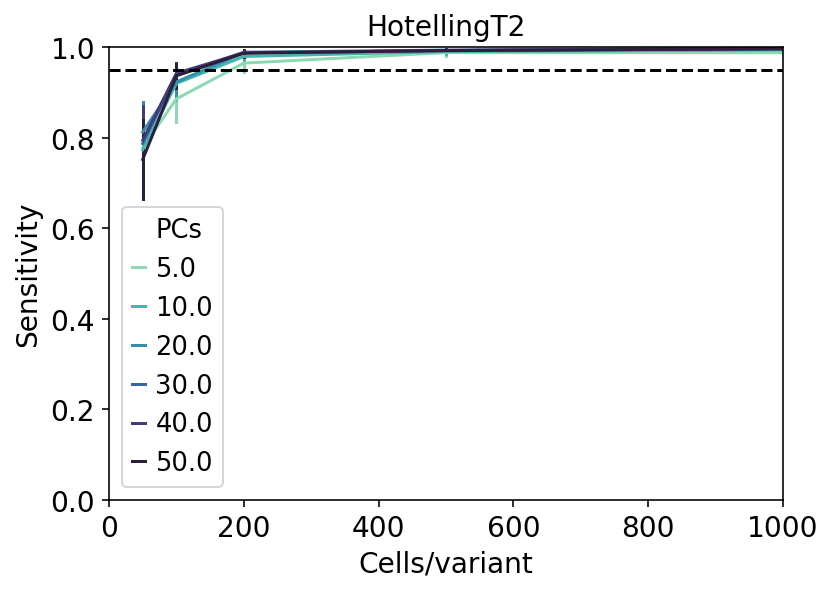

In [12]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='PCs', 
    #cmap='tab20',
    err_style="bars",
    palette=sns.color_palette("mako_r", 6),
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.png',bbox_inches = "tight")
plt.show()

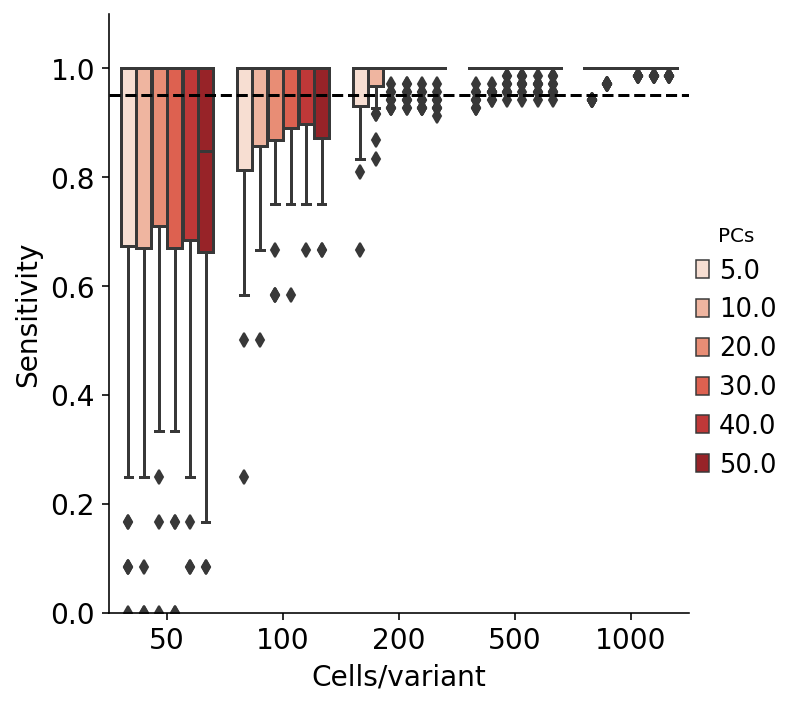

In [13]:
#how to make lines with error bars
method='HotellingT2'

sns.catplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='PCs', kind='box',
    #cmap='tab20',
    #err_style="bars",
    palette=sns.color_palette("Reds", 6),
    #ci=95,
)
plt.ylim(0,1.1)
#plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.PCs.png',bbox_inches = "tight")
plt.show()

In [ ]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)

def compare_two_groups(adata_here,
                       grouping_variable,
                       g1,g2,
                       methods=['HotellingT2','avg.pearson','avg.spearman','avg.L1'],
                       num_pcs_hotelling=20):
    
    #convert the adata to a data frame here
    data_here=pd.DataFrame(adata_here.X,
                          columns=adata_here.var_names,
                         index=adata_here.obs_names)
    if 'HotellingT2' in methods:
        data_here_pca=pd.DataFrame(adata_here.obsm['X_pca'][:,:num_pcs_hotelling],
                             index=adata_here.obs_names)
    
    g1_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g1]
    g2_cells=adata_here.obs_names[adata_here.obs[grouping_variable]==g2]
    
    comparison_name=g1+'.VS.'+g2
    cols=['group1','group2']
    for m in methods:
        cols.append(m)
    df_comparison=pd.DataFrame(0,columns=cols,index=[comparison_name])
    
    for method in methods:
        if method=='HotellingT2':
            v=compare_2_groups_df(data_here_pca,g1_cells,g2_cells,method)
        else:
            v=compare_2_groups_df(data_here,g1_cells,g2_cells,method)
        df_comparison.loc[comparison_name,method]=v
        df_comparison.loc[comparison_name,'group1']=g1
        df_comparison.loc[comparison_name,'group2']=g2
    df_comparison=df_comparison.reset_index(drop=True)
        
    return(df_comparison)

def get_conf_interval(data,ci_size=0.95):
    from scipy.stats import t, sem

    #create 95% confidence interval for population mean weight
    ci1,ci2=t.interval(alpha=ci_size, df=len(data)-1, 
               loc=np.mean(data), scale=sem(data)) 
    return(ci1,ci2)

#convert our scores to empirical p-values
def empirical_pvalues(values_df,empirical_dist):
    
    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5):
    plt.hist(ps,30)
    plt.show()
    thresh=0.5
    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)

def get_threshold_at_FDR(fdr_data,method,FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data['FDR.'+method]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)

def compute_FDR(res_true,res_perm,methods,plot=False,FDR=0.01):
    
    res_true['dataset']='true data'
    res_perm['dataset']='permuted data'
    to_return={}
    
    for method in methods:
        res_combo=pd.concat([res_true.loc[:,['dataset','group2',method]],
                             res_perm.loc[:,['dataset','group2',method]]],axis=0)
        min_fdr=1.0/res_combo.shape[0]
        print('min fdr',min_fdr,res_combo.shape)
        res_combo=res_combo.sort_values(by=method,ascending=False)
        res_combo['FDR.'+method]=1
        res_combo=res_combo.reset_index(drop=True)
        for i in range(res_combo.shape[0]):
            value_here=float(list(res_combo[method])[i])
            idx=list(res_combo.index)[i]
            passed=res_combo.loc[res_combo[method]>=value_here,:]
            true_pass=np.sum(passed['dataset']=='true data')
            perm_pass=np.sum(passed['dataset']=='permuted data')
            
            true_fraction=1.0*true_pass/res_true.shape[0]
            perm_fraction=1.0*perm_pass/res_perm.shape[0]
            
            fdr_here=max(float(1.0*perm_fraction/(perm_fraction+true_fraction)),
                            float(min_fdr)) 
            res_combo.loc[idx,'FDR.'+method]=float(fdr_here)
        to_return[method]=res_combo.loc[res_combo['dataset']=='true data',:]
        to_return[method]=to_return[method].drop(columns=['dataset'])
        to_return[method].index=list(to_return[method]['group2'])
            
        if plot:
            #get even bins
            NUM_BINS=20
            max_val=np.max(res_combo[method])
            mybins=[x*max_val/NUM_BINS for x in range(NUM_BINS)]
            scores_true=res_combo.loc[res_combo['dataset']=='true data',method]
            scores_perm=res_combo.loc[res_combo['dataset']=='permuted data',method]
            plt.hist(scores_true,color='red',bins=mybins,label='Real data')
            plt.hist(scores_perm,color='black',alpha=0.5,bins=mybins,
                     weights=[len(scores_true)/len(scores_perm)]*len(scores_perm),
                    label='Permuted data')
            plt.grid(False)
            plt.xlabel(method)
            plt.ylabel('Frequency')
            #thresh_data=res_combo.loc[res_combo['FDR.'+method]<=0.01,:]
            #thresh_data=thresh_data.sort_values(by=method,ascending=True)
            #thresh=list(thresh_data[method])[0]
            thresh=get_threshold_at_FDR(res_combo.loc[res_combo['dataset']=='true data',:],method,FDR)
            thresh=int(1000*thresh)/1000
            plt.axvline(x=thresh,color='black',linestyle='dotted')
            plt.title('FDR '+str(FDR)+' threshold: '+str(thresh))
            plt.legend()
            plt.show()
            
    return(to_return)


def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=20):
    
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
    
    import copy
    followup=copy.deepcopy(groups)
    for c in controls_for_ci_found:
        followup.append(c)
    followup=list(set(followup))
    counter=0
    for group in followup:
        counter+=1
        perturb.util.display_progress(counter,len(followup))
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        if len(controls_for_ci_found)>0:
            control_scores={}
            #get scores for each control, so we can compute a confidence interval
            for ctrl in controls_for_ci_found:
                if ctrl==group:
                    continue
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
        
    #FDR control
    p_d={}
    emp_d={}
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        
        emp_scores=np.array(score_mat[method].loc[controls,controls].astype(float)).flatten()
        emp_scores = emp_scores[~np.isnan(emp_scores)]
        emp_scores_df=pd.DataFrame({method:emp_scores})
        plt.hist(emp_scores)
        plt.show()
        
        #q-values
        emp_p=empirical_pvalues(data[method],emp_scores)

        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        print(data[method+'.q'])
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        p_d[method]=emp_p
        emp_d[method]=emp_scores
        
    return(data,score_mat,p_d,emp_d)

In [ ]:
#### works




def compare_groups_with_reference(adata_here,
                                  grouping_variable,
                                 groups,
                                 reference,
                                  controls_for_ci=[],
                                  ci_size=0.95,
                                 methods=['avg.pearson'],
                                 num_pcs_hotelling=20):
    
    #checks 
    import copy
    if grouping_variable not in adata_here.obs:
        print('ERROR: grouping variable "'+grouping_variable+'" is not in adata.obs')
        return 
    
    total_groups=list(set(adata_here.obs[grouping_variable]))
    if reference not in total_groups:
        print('ERROR: reference group "'+reference+'" is not in adata.obs['+grouping_variable+']')
        return 
    controls_for_ci_found=list(set(total_groups).intersection(set(controls_for_ci)))
    if len(controls_for_ci)>0:
        print('Found '+str(len(controls_for_ci_found))+'/'+str(len(controls_for_ci))+' controls for CI computation')
  
  
    #for storing results
    data_col=['group1','group2']
    for c in methods:
        data_col.append(c)
    data=pd.DataFrame(columns=data_col)
    
    #compute a matrix with scores for groups vs all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_for_ci,
                                      columns=groups)
    #total list of groups to test = groups + ones for CI
    totest=list(set(groups).union(set(controls_for_ci_found)))
    
    #go through each test
    counter=0
    for group in totest:
        counter+=1
        perturb.util.display_progress(counter,len(totest))
        
        if group not in total_groups:
            print('WARNING: group "'+group+'" is not in adata.obs['+grouping_variable+']. Skipping')
            return
        
        #test group vs reference
        data_here=compare_two_groups(adata_here,
                               grouping_variable,
                     reference,group,
                    methods,
                    num_pcs_hotelling)
        
        #compute CI for this group
        if len(controls_for_ci_found)>0:
            control_scores={}
            #score against each control
            for ctrl in controls_for_ci_found:
                if ctrl==group:
                    continue
                res_ctrl=compare_two_groups(adata_here,
                               grouping_variable,
                     ctrl,group,
                    methods,
                    num_pcs_hotelling)
                
                for method in methods:
                    if method not in control_scores.keys():
                        control_scores[method]=[]
                    ctrl_score_here=float(res_ctrl[method])
                    score_mat[method].loc[ctrl,group]=ctrl_score_here
                    control_scores[method].append(ctrl_score_here)
                    
            for method in methods:
                #create confidence intervals for each method
                conf_intervals=get_conf_interval(control_scores[method],ci_size=ci_size)
                data_here[method+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
                data_here[method+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
                data_here[method+'.ci.'+str(ci_size)+'.mean']=np.mean(control_scores[method])
            
        data=pd.concat([data,data_here],axis=0,sort=True)
    data.index=list(data['group2'])
    
        
    #FDR control
    p_d={}
    emp_d={}
    for method in methods:
        controls=list(set(controls_for_ci_found).difference(set([reference])))
        
        emp_scores=np.array(score_mat[method].loc[controls,controls].astype(float)).flatten()
        emp_scores = np.array(emp_scores[~np.isnan(emp_scores)]).flatten()
        emp_scores_df=pd.DataFrame({method:emp_scores})
        plt.hist(emp_scores)
        plt.show()
        
        #q-values
        emp_p=empirical_pvalues(data[method+'.ci.'+str(ci_size)+'.mean'],emp_scores)
        print('computed ps===',emp_p)

        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        data[method+'.q']=qvalue(np.array(emp_p_combo))[:data[method].shape[0]]
        print(data[method+'.q'])
        
        #FDR
        fdr_data2=compute_FDR(data,
                                emp_scores_df,
                                methods=[method],
                                plot=False)[method]
        data[method+'.FDR']=fdr_data2.loc[data.index,'FDR.'+method]
        p_d[method]=emp_p
        emp_d[method]=emp_scores
        
    return(data,score_mat,p_d,emp_d)

In [ ]:
def empirical_pvalues(values_df,empirical_dist):

    values=list(values_df)
    from scipy import stats
    ps=[]
    for i in range(len(values)):
        p=(100.0-stats.percentileofscore(empirical_dist,values[i]))/100.0
        ps.append(p)
    return(np.array(ps))

def qvalue(ps,mini=1e-5,thresh=0.5):

    total=ps.shape[0]
    above=(ps>thresh).sum()
    exp_fp=int(above*(1.0/thresh))
    pi_0=1.0*exp_fp/total

    qs=[]
    for p_idx in range(ps.shape[0]):
        p=ps[p_idx]
        R=(ps<=p).sum()
        q=max(1.0*p*total*pi_0/R,mini)
        qs.append(q)
    return(qs)


def compare_2_groups_df(cellsxvalues,
                     group1_cells,group2_cells,
                     method):
    
    g1_data=cellsxvalues.loc[group1_cells,:]
    g2_data=cellsxvalues.loc[group2_cells,:]

    #T2 Hotelling
    #============
    if method=='HotellingT2':
        import spm1d
        
        T2=spm1d.stats.hotellings2(g1_data,g2_data)
        value=T2.z #the T2 statistic

    #bulk analysis
    #==============
    if 'avg' in method:
        #get the averaged data
        g1_bulk=np.mean(np.array(g1_data),axis=0)
        g2_bulk=np.mean(np.array(g2_data),axis=0)

    if method=='avg.pearson':
        from scipy.stats import pearsonr
        value=1-pearsonr(g1_bulk,g2_bulk)[0]

    if method=='avg.spearman':
        from scipy.stats import spearmanr
        value=1-spearmanr(g1_bulk,g2_bulk)[0]
        
    if method=='avg.L1':
        from scipy.spatial.distance import cityblock
        value=cityblock(g1_bulk,g2_bulk)

    return(value)


def df_to_CI(res_df,score_cols,controls,control_col='group2',test_col='group1',ci_size=0.95):
    
    res_df.index=range(res_df.shape[0])
    groups=list(set(res_df[test_col]))
    res_cols=[]
    for score_col in score_cols:
        res_cols.append(score_col+'.mean')
        res_cols.append(score_col+'.ci.'+str(ci_size)+'.low')
        res_cols.append(score_col+'.ci.'+str(ci_size)+'.high')
        
    res_ci=pd.DataFrame(index=groups,columns=res_cols)
    for score_col in score_cols:
        for group in groups:
            rows=list(set(list(res_df.loc[res_df[test_col]==group,:].index)).intersection(set(list(res_df.loc[res_df[control_col].isin(controls),:].index))))
            group_scores=res_df.loc[rows,score_col]
            conf_intervals=get_conf_interval(group_scores,ci_size=ci_size)
            res_ci.loc[group,score_col+'.ci.'+str(ci_size)+'.low']=conf_intervals[0]
            res_ci.loc[group,score_col+'.ci.'+str(ci_size)+'.high']=conf_intervals[1]
            res_ci.loc[group,score_col+'.mean']=np.mean(group_scores)
    return(res_ci)

def get_empirical_q(res_full,res_ci,
                    controls,
                    score_cols,
                    control_col='group2',test_col='group1'):

    for score_col in score_cols:
        
        rows1=list(res_full.loc[res_full[control_col].isin(controls),:].index)
        rows2=list(res_full.loc[res_full[test_col].isin(controls),:].index)
        rows=list(set(rows1).intersection(set(rows2)))
        
        emp_scores=np.array(res_full.loc[rows,score_col].astype(float)).flatten()
        emp_scores = np.array(emp_scores[~np.isnan(emp_scores)]).flatten()
        
        #q-values
        emp_p=empirical_pvalues(res_ci[score_col+'.mean'],emp_scores)
        emp_p_ctrl=empirical_pvalues(emp_scores,emp_scores)
        emp_p_combo=list(emp_p)
        for p in emp_p_ctrl:
            emp_p_combo.append(p)
        res_ci[score_col+'.q']=qvalue(np.array(emp_p_combo))[:res_ci.shape[0]]
    return(res_ci)

def display_progress(cur_num,max_num):
    sys.stdout.write('\r'+str(int(100*(1.0*cur_num/max_num)))+' %')
    sys.stdout.flush()

def compare_groups_with_reference(data_df,
                                  labels_df,
                                 groups,
                                  controls,
                                 methods=['HotellingT2','avg.pearson'],
                                 n_bootstrap_controls=0,
                                 rng=np.random.RandomState(1234)):
    
    import copy
    groups_found=list(set(labels_df['label']))
    controls_found=list(set(groups_found).intersection(set(controls)))
    if len(controls_found)>0:
        print('Found '+str(len(controls_found))+'/'+str(len(controls_found))+' controls')
    else:
        print('ERROR: No controls found.')
        return()
    
    #setup result data
    res_col=['group1','group2']
    for c in methods:
        res_col.append(c)
    res=pd.DataFrame(columns=res_col)
    
    #score groups against all controls, and all controls against all controls
    score_mat={}
    for method in methods:
        score_mat[method]=pd.DataFrame(index=controls_found,columns=groups_found)
        
    #get group cells 
    group_cells_d={}
    for group in groups:
        if group not in groups_found:
            print('WARNING: group "'+group+'" is not in label data frame. Skipping')
            return
        group_cells=list(labels_df.loc[labels_df['label']==group].index)
        group_cells_d[group]=group_cells
        
    #get control cells
    control_cells_d={}
    controls_found_plus_bootstraps=[]
    for control in controls_found:
        controls_found_plus_bootstraps.append(control)
        control_cells=list(labels_df.loc[labels_df['label']==control].index)
        control_cells_d[control]=control_cells
        #if bootstrapping, sample with replacement from the control cells
        for b in range(n_bootstrap_controls):
            control_cells_d[control+'boot'+str(b)]=rng.choice(control_cells,size=len(control_cells))
            controls_found_plus_bootstraps.append(control+'boot'+str(b))
        
    #score groups against all controls
    counter=0
    for group in groups:
        group_cells=group_cells_d[group]
        counter+=1
        display_progress(counter,len(groups_found))
        
        for control in controls_found_plus_bootstraps:
            if control==group:
                continue
            #group is a test group and control is a bootstrapped one, skip test
            if group not in controls_found and control not in controls_found:
                continue
            control_cells=control_cells_d[control]
            res_here=pd.DataFrame({'group1':[group],
                                  'group2':[control]},index=[group+'.'+control])
            
            for method in methods:
                method_score=compare_2_groups_df(data_df.loc[list(set(group_cells).union(set(control_cells))),:],
                     group_cells,control_cells,
                     method)
                
                res_here[method]=method_score    
        
            res=pd.concat([res,res_here],axis=0,sort=True)
    res.index=list(res['group2'])
    
    #make confidence intervals
    res_ci=df_to_CI(res,methods,
                    controls_found_plus_bootstraps,
                    control_col='group2',
                    test_col='group1',
                    ci_size=0.95)
    
    #get qvalues from empirical p-values
    res_ci=get_empirical_q(res,res_ci,
                    controls=controls_found_plus_bootstraps,
                    control_col='group2',test_col='group1',
                    score_cols=methods)
    
    return(res_ci)
        
 

In [ ]:
dataset=pd.DataFrame(adata.X,index=adata.obs_names,
                    columns=adata.var_names)
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

In [ ]:
dataset=pd.DataFrame(adata.X,index=adata.obs_names,
                    columns=adata.var_names)
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

res_out=compare_groups_with_reference(dataset,
                                  labels,
                                 list(set(labels['label'])),
                                  syn,
                                 methods=['avg.pearson'],
                                 n_bootstrap_controls=1)       

In [ ]:
dataset=pd.DataFrame(adata.obsm['X_pca'][:,:20],
                     index=adata.obs_names,
                    columns=range(20))
labels=pd.DataFrame({'label':adata.obs['guide.compact']})
labels.index=adata.obs_names

In [ ]:
res_out=compare_groups_with_reference(dataset,
                                  labels,
                                 list(set(labels['label'])),
                                  syn,
                                 methods=['HotellingT2'],
                                 n_bootstrap_controls=1) 

In [ ]:
x=res_out

In [ ]:
x.loc[syn,:]

In [ ]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)


res={}
outs={}
methods=['HotellingT2','avg.pearson','avg.L1']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP'])
    

    


In [ ]:
for i in range(1):
    outs[i]={}
    for subs in [1000,#50,40,30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
                
    ]:
        outs[i][subs]={}
        print('cells',subs)
        
        out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        cell_ids=list(pd.read_csv(out).iloc[:,0])

        #get subsample
        adata_sub=adata[cell_ids,:].copy()

        #compute scores and their FDRs
        scores_real2=compare_groups_with_reference(adata_sub,
                                  grouping_variable='guide.compact',
                                 groups=variants,
                                 reference=ref,
                                  controls_for_ci=syn,
                                  ci_size=0.95,
                                 methods=['HotellingT2','avg.pearson'],
                                 num_pcs_hotelling=min(20,subs-1))[0]

        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2.to_csv(out2)

In [ ]:
outs[0].loc[syn,:]

In [ ]:
method='HotellingT2'
empirical_pvalues(outs[1][method].loc['P359P',syn],outs[3][method])

In [ ]:
outs[3][method]

In [ ]:
outs[3][method].sort()
print(outs[3][method])

In [ ]:
vs=list(outs[0][method].index)
print(ps)
ps=pd.DataFrame({'p':list(ps)},index=vs)

In [ ]:
ps.loc[syn]

In [ ]:
outs[1][method].loc['P359P',syn].sort_values()

In [ ]:
qvalue(ps)

In [ ]:
scores.head()

In [ ]:
#get the impactful as the ones called at 1000 cells
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)


In [ ]:
SUBS_DIR=DATA+'/'+PROTEIN+'/scoring/subsamples'
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
os.system('mkdir -p '+SCORE_DIR)

def get_precision_recall(score_df,colname,trues,fdr):
    
    sigs=list(score_df.loc[score_df[colname]<=fdr,:].index)
    print('true',len(trues))
    recall_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(list(trues))
    if len(sigs)==0:
        precision_here=0.0
    else:
        precision_here=1.0*len(list(set(sigs).intersection(set(trues))))/len(sigs)
    return(precision_here,recall_here)

res={}
outs={}
methods=['HotellingT2','avg.pearson']
for method in methods:
    res[method]=pd.DataFrame(columns=['cells','recall','FDR','FP','cluster'])


fdr_total=0.05
thestat='.q'
for i in range(3):
    print(i)
    outs[i]={}
    for subs in [1000,200,#50,40,30,20,10,
        #1000,900,800,700,600,500,400,300,200,
        #         190,180,170,160,150,140,130,120,110,
        #         100,90,80,70,60,
    ]:
        outs[i][subs]={}
        
        out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
        scores_real2=pd.read_csv(out2,index_col=0)
        print(scores_real2.head())

        for fdr in [fdr_total]:

            for method in methods:
                
                #all variants
                #============
                #get impactful variants
                impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                print(method,fdr,'impactful',len(impactful))
                
                pre,rec=get_precision_recall(scores_real2,
                                             method+thestat,
                                             impactful,fdr)
                res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':'all',
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                res[method]=pd.concat([res[method],res_here])
                
                '''
                #now, go through each cluster of variants and compute (vs original ctrls)
                for cl in ['#99CCFF', 'navy']:
                    cl_variants=list(anno.loc[anno['cluster_color']==cl,:].index)
                    cl_variants_sig=list(set(cl_variants).intersection(set(impactful)))
                    variants_here=list(set(cl_variants).union(set(ctrls)))
                    pre,rec=get_precision_recall(scores_real2.loc[variants_here,:],
                                             method+thestat,
                                             cl_variants_sig,
                                                 fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                      'recall':rec,
                                      'FDR':fdr,
                                       'cluster':cl,
                                      'FP':1.0-pre},
                                      index=[str(subs)+'.'+str(fdr)+'.'+str(i)+'.cl'+cl])
                    res[method]=pd.concat([res[method],res_here])
                '''
                
    

In [ ]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='cluster', 
    #cmap='tab20',
    #err_style="bars",
    palette={'navy':'navy','black':'black','#99CCFF':'#99CCFF','all':'gray'},
    ci=95,
)
plt.ylim(-0.05,0.2)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
sorted_variants_df=pd.read_csv(DATA+'/'+PROTEIN+'/clustering/'+PROTEIN+'.corrL1.sorted_variants.csv',header=None)
sorted_variants=list(sorted_variants_df[0])
print(sorted_variants)

In [ ]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    print('new')
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)


subs_list=[1000,900,800,700,600,500,400,300,200,100,50]


methods=['HotellingT2','avg.pearson']
for method in methods:
    SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
    scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
    scores=pd.read_csv(scorefile,header=0,index_col=0)
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.loc[variants,:]
    anno=anno.sort_values(by=[method+'.ci.0.95.mean'],ascending=True)

    fig,plots=plt.subplots(len(subs_list),1)
    fig.set_size_inches(5,10)
    c=0
    for subs in subs_list:

        SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
        scorefile=SCORE_DIR+'/scores.iter0.cells'+str(subs)+'.cells.csv'
        scores=pd.read_csv(scorefile,header=0,index_col=0)        

        w=10
        h=6
        
        plot_with_errorbars(list(anno.index),
                            scores.loc[anno.index,method+'.ci.0.95.mean'],
                           scores.loc[anno.index,method+'.ci.0.95.low'],
                           scores.loc[anno.index,method+'.ci.0.95.high'],
                            plots=plots[c],
                            flip_axes=False,
                            color_lines=list(anno.loc[anno.index,'cluster_color']),

                            s=5,
                           c=list(anno.loc[anno.index,'cluster_color']))

        if method=='avg.pearson':
            plots[c].set_ylabel('1 - Pearson correlation\n(variant vs WT)')
            #plots[c].set_ylim(0,1.5)
            #plots[c].set_yticks([0,0.5,1.0,1.5])
        if method=='HotellingT2':
            plots[c].set_ylabel('HotellingT2')
            #plots.set_ylim(0,1.5)
            #plots.set_yticks([0,0.5,1.0,1.5])
        plots[c].set_xticklabels([])
        plots[c].set_xlim(-1,101)

        #figure out FDR line
        #thresh=get_threshold_at_FDR(scores,method,statname='.q',FDR=0.05)
        #plots[c].axhline(y=thresh,color='black',linestyle='--',linewidth=0.5)
        plots[c].set_title(str(subs))
        c+=1
    plt.show()

Analyze scores as a function of number of PCs
===

In [ ]:
for i in range(2):
    outs[i]={}
    for subs in [1000,200,50,
                
    ]:
        
        for pc in [10,30,50]:
            print('cells',subs)

            out=SUBS_DIR+'/subsample.iter'+str(i)+'.cells'+str(subs)+'.cells.csv'
            cell_ids=list(pd.read_csv(out).iloc[:,0])

            #get subsample
            adata_sub=adata[cell_ids,:].copy()

            #compute scores and their FDRs
            scores_real2=compare_groups_with_reference(adata_sub,
                                      grouping_variable='guide.compact',
                                     groups=variants,
                                     reference=ref,
                                      controls_for_ci=syn,
                                      ci_size=0.95,
                                     methods=['HotellingT2','avg.pearson'],
                                     num_pcs_hotelling=min(pc,subs-1))[0]

            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.pc'+str(pc)+'.csv'
            scores_real2.to_csv(out2)

In [ ]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)

In [ ]:
for i in range(2):
    outs[i]={}
    for subs in [1000,200,50,
                
    ]:
        
        for pc in [10,30,50]:
            print('cells',subs)
            
            out2=SCORE_DIR+'/scores.iter'+str(i)+'.cells'+str(subs)+'.cells.pc'+str(pc)+'.csv'
            scores_real2=pd.read_csv(out2,index_col=0)

            for fdr in [fdr_total]:

                for method in methods:

                    #all variants
                    #============
                    #get impactful variants
                    impactful=list(scores.loc[scores[method+thestat]<=fdr,:].index)
                    ctrls=list(scores.loc[scores[method+thestat]>fdr,:].index)
                    print(method,fdr,'impactful',len(impactful))

                    pre,rec=get_precision_recall(scores_real2,
                                                 method+thestat,
                                                 impactful,fdr)
                    res_here=pd.DataFrame({'cells':subs,
                                          'recall':rec,
                                          'FDR':fdr,
                                           'pc':pc,
                                          'FP':1.0-pre},
                                          index=[str(subs)+'.'+str(fdr)+'.'+str(i)])
                    res[method]=pd.concat([res[method],res_here])
            
            

In [ ]:
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="recall",hue='pc', 
    #cmap='tab20',
    err_style="bars",
    
    ci=68,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.show()



In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method].loc[res[method]['FDR']==fdr_total,:], 
    x="cells", y="FP",hue='pc', 
    #cmap='tab20',
    #err_style="bars",
    ci=68,
)
plt.ylim(-0.05,0.2)
plt.xlim(0,1000)
plt.axhline(y=fdr_total,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.show()

In [ ]:
plt.plot(adata.uns['pca']['variance']/adata.n_vars*100,
        color='black')
plt.axvline(x=20,color='red',linestyle='--')
plt.xlabel('PC')
plt.ylabel('Percent variance explained')
plt.grid(False)

In [ ]:
adata.uns['pca']['variance']/adata.n_vars*100

In [ ]:
#how to make lines with error bars
method='HotellingT2'

sns.lineplot(
    data=res[method].loc[res[method]['FDR']==0.01,:], 
    x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'gray'},
    ci=95,
)
plt.ylim(0,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

#how to make lines with error bars
method='avg.pearson'

sns.lineplot(
    data=res[method], x="cells", y="recall",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(0,1.1)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.95,color='black',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('Sensitivity')
plt.title(method)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()


In [ ]:
method='HotellingT2'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,1.0)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.grid(False)
plt.xlabel('Cells/variant')
plt.ylabel('FP')
#plt.axvline(x=100)
#plt.axvline(x=200)
#plt.axvline(x=300)
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

method='avg.pearson'

res[method]['FP']=res[method]['FP'].astype(float)
sns.lineplot(
    data=res[method], x="cells", y="FP",hue='FDR', 
    #cmap='tab20',
    #err_style="bars",
    palette={0.1:'blue',0.05:'red',0.01:'orange'},
    ci=95,
)
plt.ylim(-0.05,1.0)
plt.grid(False)
plt.xlim(0,1000)
plt.axhline(y=0.1,color='blue',linestyle='--')
plt.axhline(y=0.01,color='orange',linestyle='--')
plt.xlabel('Cells/variant')
plt.ylabel('FP')
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/RecallatFDR.'+method+'.'+PROTEIN+'.png',bbox_inches = "tight")
plt.show()

In [ ]:
SCORE_DIR=DATA+'/'+PROTEIN+'/scoring/scores'
scorefile=SCORE_DIR+'/scores.iter0.cells1000.cells.csv'
scores=pd.read_csv(scorefile,header=0,index_col=0)
anno=anno.loc[variants,:]

In [ ]:
def plot_with_errorbars(x,y,y_low,y_high,plots,flip_axes=False,color_lines=None,**kwargs):
    
    if not flip_axes:
        plots.scatter(x,y,**kwargs)
        
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot((v,v),
             (low,high),linewidth=1,color=color_lines[i])
            else:
                plots.plot((v,v),
             (low,high),linewidth=1,color='black')
                
        
    else:
        plots.scatter(y,x,**kwargs)
        for i in range(len(list(x))):
            low=list(y_low)[i]
            high=list(y_high)[i]
            v=list(x)[i]
            if color_lines!=None:
                plots.plot(
             (low,high),(v,v),linewidth=1,color=color_lines[i])
            else:
                plots.plot(
             (low,high),(v,v),linewidth=1,color='black')
        
    plots.grid(False)
    
def get_threshold_at_FDR(fdr_data,method,statname='.q',FDR=0.1,higher=True):
    fdr_passed=fdr_data.loc[fdr_data[method+statname]<=FDR,:]
    if higher:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=True)
    else:
        fdr_passed=fdr_passed.sort_values(by=method,ascending=False)
    score_thresh_value=float(list(fdr_passed[method])[0])
    return(score_thresh_value)
    
methods=['HotellingT2','avg.pearson']
for method in methods:
    anno[method+'.ci.0.95.mean']=scores.loc[anno.index,method+'.ci.0.95.mean']
    anno['control_status2']=pd.Categorical(anno['control_status2'],['synonymous','ExAC','hotspot','unknown'])
    anno=anno.sort_values(by=['control_status2',method+'.ci.0.95.mean'],ascending=True)

    w=10
    h=6
    fig,plots=plt.subplots(1)
    fig.set_size_inches(w,h)
    plot_with_errorbars(list(anno.index),
                        scores.loc[anno.index,method+'.ci.0.95.mean'],
                        #scores.loc[anno.index,method],
                       scores.loc[anno.index,method+'.ci.0.95.low'],
                       scores.loc[anno.index,method+'.ci.0.95.high'],
                        plots=plots,
                        flip_axes=False,
                        color_lines=list(anno.loc[:,'text_color']),

                        s=10,
                       c=list(anno.loc[:,'text_color']))
    plots.axvline(x=14.5,color='lightgray')
    plots.axvline(x=24.5,color='lightgray')
    plots.axvline(x=30.5,color='lightgray')
    if method=='avg.pearson':
        plots.set_ylabel('1 - Pearson correlation\n(variant vs WT)')
        plots.set_ylim(0,1.5)
        plots.set_yticks([0,0.5,1.0,1.5,2.0])
    if method=='HotellingT2':
        plots.set_ylabel('HotellingT2')
        #plots.set_ylim(0,1.5)
        #plots.set_yticks([0,0.5,1.0,1.5])
    plots.set_xticklabels([])
    plots.set_xlim(-1,101)
    plots.set_xticks([6,20,28,70])
    plots.set_xticklabels(['synonymous','ExAC','hotspot','unknown'],rotation=45,
                         ha='right')

    #figure out FDR line
    thresh=get_threshold_at_FDR(scores,method,statname='.FDR',FDR=0.05)
    print('thresh',thresh)
    plt.axhline(y=thresh,color='black',linestyle='--')
    plt.show()

In [ ]:
scores.loc[syn,:].sort_values(by='HotellingT2.ci.0.95.mean')

In [ ]:
scores.loc[syn,].sort_values(by='HotellingT2.q')